## Imports

In [75]:
%load_ext autoreload
%autoreload 2

import os 
import sys
sys.path.append('./..')
import zipfile
import tarfile

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from ipywidgets import interact

import dynaphos
from dynaphos import utils
from dynaphos import cortex_models
from dynaphos.cortex_models import get_visual_field_coordinates_from_cortex_full, Map
from dynaphos.image_processing import canny_processor, sobel_processor
from dynaphos.simulator import GaussianSimulator as PhospheneSimulator
from dynaphos.utils import get_data_kwargs, to_numpy

from sklearn.neighbors import KDTree
from scipy.spatial import Voronoi
from scipy.spatial import Delaunay
from scipy.interpolate import RBFInterpolator

from components.fov_conv2d_cont import FovConv2dCont

sys.path.append('../data/EGTEA/Gaze_Data/gaze_data') 
from gaze_io_sample import parse_gtea_gaze

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# GTEA Gaze+ Dataset
EGTEA Gaze+ is by far **the largest and most comprehensive** dataset for First Person Vision (**FPV**), with an emphasis on FPV action recognition and gaze estimation. The dataset comes with first person videos, gaze tracking data, densely annotated action labels and sparsely annotated hand masks. 

In [76]:
# # Define the root directory where all the zips are located
# root_dir = "../data/EGTEA"  # Replace with the path to your EGTEA folder

# # Walk through all subdirectories and extract zip files
# for subdir, dirs, files in os.walk(root_dir):
#     for file in files:
#         if file.endswith(".zip"):
#             zip_path = os.path.join(subdir, file)
#             extract_to = subdir  # Extract to the same directory as the zip file
            
#             print(f"Extracting {zip_path} to {extract_to}...")
#             with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#                 zip_ref.extractall(extract_to)
#             print(f"Finished extracting {file}")

# # Define the root directory where all the tar files are located
# root_dir = "../data/EGTEA"  # Replace with the path to your EGTEA folder

# # Walk through all subdirectories and extract tar files
# for subdir, dirs, files in os.walk(root_dir):
#     for file in files:
#         if file.endswith(".tar"):  # Check for tar files
#             tar_path = os.path.join(subdir, file)
#             extract_to = subdir  # Extract to the same directory as the tar file
            
#             print(f"Extracting {tar_path} to {extract_to}...")
#             with tarfile.open(tar_path, 'r') as tar_ref:
#                 tar_ref.extractall(extract_to)
#             print(f"Finished extracting {file}")

In [77]:
file_name = "OP01-R01-PastaSalad"

# Path to the gaze data file
gaze_data_path = f"../data/EGTEA/Gaze_Data/gaze_data/gaze_data/{file_name}.txt"
gaze_data = parse_gtea_gaze(gaze_data_path)
gaze_data.shape

# Path to the video file
video_path = f"../data/EGTEA/Raw_Videos/{file_name}.mp4"

Frame 50: Gaze Point (0.57, 0.56), Gaze Type: 1


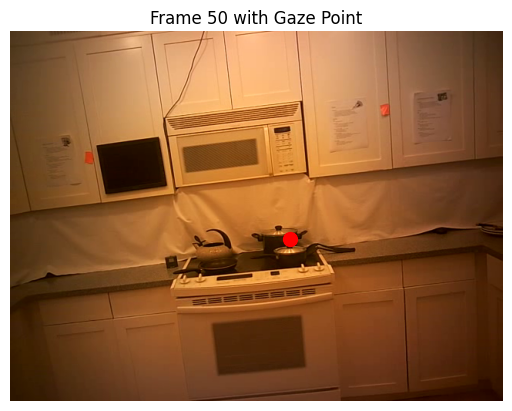

In [78]:
# Index of the frame to analyze
frame_i = 50

# Open the video
cap = cv2.VideoCapture(video_path)

# Get the gaze data for the specific frame
gaze_point = gaze_data[frame_i, :]

if gaze_point[2] == 4:  # Gaze truncated (out of bounds)
    print(f"Frame {frame_i}: Gaze point out of bounds.")
else:
    gaze_x, gaze_y = gaze_point[0], gaze_point[1]  # Normalized coordinates
    gaze_type = int(gaze_point[2])
    print(f"Frame {frame_i}: Gaze Point ({gaze_x:.2f}, {gaze_y:.2f}), Gaze Type: {gaze_type}")

# Set the video to the desired frame
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_i)
ret, frame = cap.read()

if ret:
    # Denormalize gaze coordinates to image resolution
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    gaze_x_px = int(gaze_point[0] * frame_width)
    gaze_y_px = int(gaze_point[1] * frame_height)

    # # Overlay the gaze point on the frame
    # cv2.circle(frame, (gaze_x_px, gaze_y_px), radius=10, color=(0, 0, 255), thickness=-1)  # Red dot

    # Display the frame with Matplotlib
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    # overlay the gaze point
    plt.scatter(gaze_x_px, gaze_y_px, color='red', s=100)
    plt.title(f"Frame {frame_i} with Gaze Point")
    plt.axis('off')
    plt.show()
else:
    print(f"Error: Could not retrieve frame {frame_i}.")

cap.release()

146


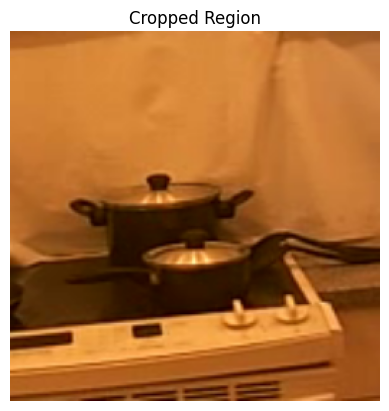

In [79]:
# Function to crop a 256x256 region centered on the gaze point
def crop_frame(frame, gaze_x, gaze_y, crop_size, resize):
    h, w, _ = frame.shape  # Height, width of the frame
    x_center = int(gaze_x * w)  # Convert normalized gaze_x to pixel value
    y_center = int(gaze_y * h)  # Convert normalized gaze_y to pixel value

    # Calculate crop boundaries
    x1 = max(0, x_center - crop_size // 2)
    y1 = max(0, y_center - crop_size // 2)
    x2 = min(w, x_center + crop_size // 2)
    y2 = min(h, y_center + crop_size // 2)

    # Crop the region
    cropped_frame = frame[y1:y2, x1:x2]

    # If the crop is smaller than 256x256 (e.g., near the frame edge), pad it
    if cropped_frame.shape[0] != crop_size or cropped_frame.shape[1] != crop_size:
        cropped_frame = cv2.copyMakeBorder(
            cropped_frame,
            top=max(0, crop_size // 2 - y_center),
            bottom=max(0, y_center + crop_size // 2 - h),
            left=max(0, crop_size // 2 - x_center),
            right=max(0, x_center + crop_size // 2 - w),
            borderType=cv2.BORDER_CONSTANT,
            value=(0, 0, 0)  # Black padding
        )

    # Resize the cropped region to 256x256
    if resize:
        cropped_frame = cv2.resize(cropped_frame, (resize, resize))

    return cropped_frame

# Define the frame resolution and crop size
camera_fov = 70  # Camera field of view in degrees, this is an estimate, i can't find online what the actual fov is
phosphene_fov = 16
# based on fovs
ratio = phosphene_fov / camera_fov 
crop_size = int(frame_width * ratio)
print(crop_size)
resize = 256  # Resize the cropped region to 256x256

# Example: Crop a 256x256 region around the gaze point
if ret:
    cropped = crop_frame(frame, gaze_x, gaze_y, crop_size=crop_size, resize=resize)

    # Display the cropped region
    plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
    plt.title("Cropped Region")
    plt.axis('off')
    plt.show()
else:
    print(f"Error: Could not retrieve frame {frame_i}.")

# Simulator

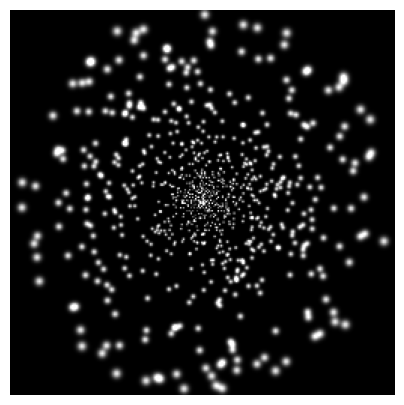

In [80]:
# Load the simulator configuration file (and adjust to preferences).
params = utils.load_params('../config/params.yaml')

# Get phosphene coordinates...
n_phosphenes = 1024
phosphene_coords = cortex_models.get_visual_field_coordinates_probabilistically(params, n_phosphenes)

# Initialize simulator
simulator = PhospheneSimulator(params, phosphene_coords)

# Stimulation amplitude
amplitude = params['sampling']['stimulus_scale'] # Ampère (160 µA)

# Stimulation vector
stim = amplitude * torch.ones(n_phosphenes).cuda() # (All electrodes are activated)

# Reset and call the simulator
simulator.reset()
phosphenes = simulator(stim)

plt.figure(figsize=(5,5))

# Show the phosphene image
plt.imshow(phosphenes.cpu(), cmap='gray')
plt.axis('off')
plt.show()

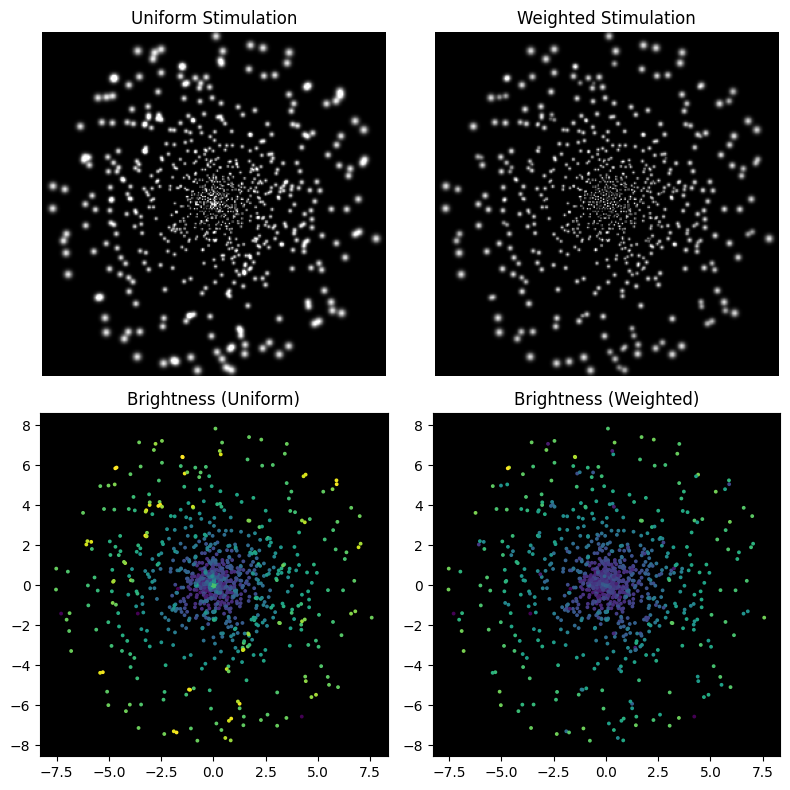

New stimulation: 84.16% of original amplitude


In [81]:
def measure_electrode_brightness_varying(
    phos_image, phos_x, phos_y,
    x_min=-8.0, x_max=8.0,
    y_min=-8.0, y_max=8.0,
    base_size=1,
    scale=0.05,
    center=(0,0)
):
    """
    For each electrode (x_i,y_i), measure brightness in `phos_image` around
    a patch whose size depends on radial distance from `center`.

    Args:
      phos_image : 2D array from the simulator (H,W), can be torch or np
      phos_x, phos_y : arrays of length N
      x_min,x_max,y_min,y_max : bounding coords to map to pixel indices
      base_size : minimal half-size of patch (like 'radius' in pixel terms)
      scale     : how much to increase the patch size per unit distance
      center    : define (cx, cy), the 'center' for radial distance

    Returns:
      brightness : 1D array of length N
    """
    # Convert to numpy if it's torch
    if isinstance(phos_image, torch.Tensor):
        phos_image = phos_image.cpu().numpy()

    H, W = phos_image.shape
    N = len(phos_x)
    brightness = np.zeros(N, dtype=float)

    cx, cy = center

    def to_pixel_coords(x, y):
        px = (x - x_min)/(x_max - x_min)*(W-1)
        py = (y - y_min)/(y_max - y_min)*(H-1)
        return int(round(px)), int(round(py))

    for i in range(N):
        # radial distance from center
        rx = phos_x[i] - cx
        ry = phos_y[i] - cy
        r_i = np.sqrt(rx*rx + ry*ry)

        # dynamic half-size of patch
        half_n = int(round(base_size + scale*r_i))
        # avoid half_n=0 if r_i=0
        half_n = max(half_n, 1)

        px, py = to_pixel_coords(phos_x[i], phos_y[i])

        vals = []
        for dx in range(-half_n, half_n+1):
            for dy in range(-half_n, half_n+1):
                qx = px + dx
                qy = py + dy
                if 0 <= qx < W and 0 <= qy < H:
                    vals.append(phos_image[qy, qx])  # (row, col) => (y, x)

        if len(vals) > 0:
            brightness[i] = np.mean(vals)
        else:
            brightness[i] = 0.0

    return brightness

def iterative_uniform_normalization_varying(
    simulator,
    phos_x, phos_y,
    stim_init,
    steps=5,
    base_size=1,
    scale=0.05,
    center=(0,0),
    A_min=1e-7,
    A_max=1e-3,
    learning_rate=0.5,
    target=None
):
    """
    Iteratively normalizes electrode amplitudes using a varying patch size
    to measure brightness in the outer region more generously.

    We'll reuse the partial update + clamping approach from before.
    """
    stim = stim_init.clone()
    N = len(phos_x)

    for step in range(steps):
        simulator.reset()
        phos_img = simulator(stim)
        # measure brightness with dynamic patch size
        b = measure_electrode_brightness_varying(
            phos_img, phos_x, phos_y,
            x_min=-8.0, x_max=8.0,
            y_min=-8.0, y_max=8.0,
            base_size=base_size,
            scale=scale,
            center=center
        )
        # define target
        if target is None:
            nonzero = b[b>1e-12]
            T = np.mean(nonzero) if len(nonzero)>0 else 1.0
        else:
            T = target

        updated = []
        for i in range(N):
            oldA = stim[i].item()
            meas = b[i]
            if meas < 1e-12:
                # small brightness => partial bump
                newA = oldA*1.1
            else:
                ratio = T/meas
                # partial update
                newA = oldA*(1.0 + learning_rate*(ratio - 1.0))

            # clamp
            if newA < A_min:
                newA = A_min
            elif newA > A_max:
                newA = A_max

            updated.append(newA)

        stim = torch.tensor(updated, device=stim.device, dtype=stim.dtype)

    return stim

phos_x = phosphene_coords._x
phos_y = phosphene_coords._y
N = len(phos_x)

stim_uniform = amplitude * torch.ones(N, device='cuda')
simulator.reset()
phos_naive = simulator(stim_uniform)

# iterative approach with dynamic patch
stim_final = iterative_uniform_normalization_varying(
    simulator,
    phos_x, phos_y,
    stim_init=stim_uniform,
    steps=50,
    base_size=1,
    scale=0.5,
    center=(0,0),
    A_min=0,
    A_max=amplitude,
    learning_rate=0.05,
    target=None  # auto-averaging
)

stim_weights = stim_final/amplitude

# test stim_weights
simulator.reset()
uniform_stimulation_sequence = torch.ones(n_phosphenes).cuda()*amplitude
phos_uniform = simulator(uniform_stimulation_sequence.cuda())

simulator.reset()
weighted_stimulation_sequence = torch.ones(n_phosphenes).cuda()*amplitude*stim_weights
phos_weighted = simulator(weighted_stimulation_sequence.cuda())

# measure brightness for uniform and weighted stim
brightness_uniform = measure_electrode_brightness_varying(
    phos_uniform, phosphene_coords._x, phosphene_coords._y,
    x_min=-8.0, x_max=8.0,
    y_min=-8.0, y_max=8.0,
    base_size=1,
    scale=0.05,
    center=(0,0)
)

brightness_weighted = measure_electrode_brightness_varying(
    phos_weighted, phosphene_coords._x, phosphene_coords._y,
    x_min=-8.0, x_max=8.0,
    y_min=-8.0, y_max=8.0,
    base_size=1,
    scale=0.05,
    center=(0,0)
)

# Plot the Uniform vs Weighted stimulation and the corresponding brightness in a 2 x 2 plot
plt.figure(figsize=(8,8))

plt.subplot(2,2,1)
plt.title("Uniform Stimulation")
plt.imshow(phos_uniform.cpu().numpy(), cmap='gray')
plt.axis('off')

plt.subplot(2,2,2)
plt.title("Weighted Stimulation")
plt.imshow(phos_weighted.cpu().numpy(), cmap='gray')
plt.axis('off')

# scatterplot of brightness for uniform vs weighted stim on the phosphene coords
plt.subplot(2,2,3)
plt.scatter(phosphene_coords._x, -phosphene_coords._y, c=brightness_uniform, cmap='viridis', s=3)
plt.title("Brightness (Uniform)")
plt.gca().set_facecolor('black')
# plt.axis('off')

plt.subplot(2,2,4)
plt.scatter(phosphene_coords._x, -phosphene_coords._y, c=brightness_weighted, cmap='viridis', s=3)
plt.title("Brightness (Weighted)")
plt.gca().set_facecolor('black')
# plt.axis('off')

plt.tight_layout()
plt.show()

# print the mean in percentages of the final weights
print(f"New stimulation: {100*stim_weights.mean():.2f}% of original amplitude")

# Fov Conv2D LoG Module

In [82]:
from components.fov_conv2d_cont import FovConv2dCont

In [83]:
# Define parameters
view_angle = params['run']['view_angle']  # Visual field angle in degrees
max_eccentricity = view_angle / 2  # Maximum eccentricity in degrees
min_eccentricity = 0.001  # Minimum eccentricity in degrees
total_phosphenes = 1024  # Total number of phosphenes
image_size = 256  # Resolution of the visual field
cortex_model_params = {
    "model": "dipole",
    "k": 17.3,
    "a": 0.75,
    "b": 120
}

# Cortical magnification function
def get_cortical_magnification(r, params):
    """Calculate cortical magnification based on eccentricity."""
    model = params["model"]
    a, b, k = params["a"], params["b"], params["k"]
    if model == "monopole":
        return k / (r + a)
    elif model == "dipole":
        return k * (1 / (r + a) - 1 / (r + b))
    else:
        raise ValueError("Unsupported cortical magnification model.")

# Calculate phosphene density map
def calculate_phosphene_density(r, params, total_phosphenes, view_angle, image_size):
    """
    Compute phosphene density map based solely on cortical magnification.
    
    Args:
        r (ndarray): Radial distances (eccentricity) in visual field space.
        params (dict): Cortical magnification model parameters.
        total_phosphenes (int): Total number of phosphenes.
        view_angle (float): Full visual field angle (in degrees).
        image_size (int): Resolution of the visual field space.

    Returns:
        ndarray: Normalized phosphene density map.
    """
    # Step 1: Calculate cortical magnification
    cortical_magnification = get_cortical_magnification(r, params) / (2 * np.pi * r)
    
    # Step 2: Scale the density map to ensure it matches the total number of phosphenes
    scaling_factor = total_phosphenes / (np.sum(cortical_magnification) * (view_angle / image_size) ** 2)
    density_map = cortical_magnification * scaling_factor
    
    # Step 3: Verify the normalization
    density_sum = np.sum(density_map) * (view_angle / image_size) ** 2
    assert np.isclose(density_sum, total_phosphenes, atol=1e-3), \
        f"Density sum mismatch: {density_sum} vs {total_phosphenes}"
    
    return density_map

# Calculate maximum frequency from density
def calculate_max_frequency_with_density(density_map):
    """Calculate the maximum frequency map based on density."""
    return np.sqrt(density_map) / 2 # Nyquist frequency is proportional to sqrt(density)

# Create a 2D grid in visual field space
x = np.linspace(-max_eccentricity, max_eccentricity, image_size)
y = np.linspace(-max_eccentricity, max_eccentricity, image_size)
xx, yy = np.meshgrid(x, y)
r = np.sqrt(xx**2 + yy**2)  # Eccentricity grid

# Compute the modeled phosphene density and max frequency maps
phosphene_density_map = calculate_phosphene_density(r, cortex_model_params, total_phosphenes, view_angle, image_size)
modeled_max_frequency_map = calculate_max_frequency_with_density(phosphene_density_map)

In [84]:
# 1) compute 2D density from your cortical magnification 
#    (via get_cortical_magnification(r)/(2pi*r) etc.) => density_map (phosphenes/deg^2)
# Create a 2D grid in visual field space
x = np.linspace(-max_eccentricity, max_eccentricity, image_size)
y = np.linspace(-max_eccentricity, max_eccentricity, image_size)
xx, yy = np.meshgrid(x, y)
r = np.sqrt(xx**2 + yy**2)  # Eccentricity grid

density_map = calculate_phosphene_density(r, cortex_model_params, total_phosphenes, view_angle, image_size)

# 2) local Nyquist frequency
fmax_map = 0.5 * np.sqrt(density_map)  # cyc/deg

# 3) LoG sigma in degrees
sigma_fov_map = 1.0 / (2.0 * np.pi * fmax_map)  # or 1/(pi * sqrt(density_map))

# 4) convert to pixels
fov = 16
sigma_map_px = sigma_fov_map * (n_phosphenes / fov)

In [85]:
from scipy.spatial.distance import cdist

def adaptive_kde_2d(phos_coords, grid_coords, k=10, alpha=1.0):
    """
    Estimate a 2D density at each point in 'grid_coords', 
    using an adaptive (variable-bandwidth) Gaussian kernel 
    centered at each phosphene location in 'phos_coords'.
    
    Args:
        phos_coords: shape (N, 2), each row is [x, y] of a phosphene in degrees
        grid_coords: shape (M, 2), each row is [x, y] location where we evaluate the density
        k (int): Which neighbor defines local bandwidth. E.g. k=10 means use dist to 10th neighbor.
        alpha (float): Optional scaling factor on the bandwidth.
        
    Returns:
        density: shape (M,) giving the adaptive density at each grid coordinate
    """
    
    # Step 1: Compute pairwise distances among phosphene coords
    #         dist_matrix[i,j] = distance between phos_coords[i] and phos_coords[j]
    dist_matrix = cdist(phos_coords, phos_coords)  # shape (N, N)
    
    # Step 2: For each phosphene i, find the distance to its k-th nearest neighbor
    dist_sorted = np.sort(dist_matrix, axis=1)  # sort each row
    kth_dist = dist_sorted[:, k]  # shape (N,), distance to the k-th neighbor
    # Multiply by alpha if desired
    local_bandwidths = alpha * kth_dist  # shape (N,)
    
    # Step 3: For each grid point, accumulate density from each phosphene
    #         Use naive O(N*M) approach (fine for moderate sizes).
    #         We'll do a standard 2D Gaussian kernel with bandwidth = local_bandwidths[j]
    #         Density at grid[i] = sum_{j=1..N} [ (1/(2 pi h_j^2)) * exp(-0.5 * (dist/h_j)^2 ) ]
    
    density = np.zeros(len(grid_coords), dtype=np.float64)
    
    # Precompute phos_coords for loop convenience
    phos_coords = np.asarray(phos_coords)
    
    for i in range(len(grid_coords)):
        # distances from this grid point to each phosphene
        d = np.linalg.norm(phos_coords - grid_coords[i], axis=1)  # shape (N,)
        
        # Gaussian kernel contribution from each phosphene
        # kernel_val_j = (1 / (2 * pi * h_j^2)) * exp(-0.5 * (d_j / h_j)^2)
        h = local_bandwidths  # shape (N,)
        
        # We'll build up the kernel for each phosphene j
        kernel_val = np.exp(-0.5 * (d / h)**2) / (2.0 * np.pi * (h**2))
        density[i] = kernel_val.sum()
    
    return density

# Phosphene coordinates (assumed to be in visual field space)
phos_x = phosphene_coords._x  # Example phosphene x-coordinates
phos_y = phosphene_coords._y  # Example phosphene y-coordinates
coords = np.column_stack((phos_x, phos_y))

x = np.linspace(-max_eccentricity, max_eccentricity, image_size)
y = np.linspace(-max_eccentricity, max_eccentricity, image_size)
xx, yy = np.meshgrid(x, y)
grid_points = np.column_stack((xx.ravel(), yy.ravel()))  # shape [image_size^2, 2]

# 1) Fit a KDE on your phosphene coords
n_neighbors = 8
density_vals = adaptive_kde_2d(coords, grid_points, k=n_neighbors, alpha=1.0)
kde_density_map = density_vals.reshape(image_size, image_size)

# 3) Normalize the density map so that it sums up to the total number of phosphenes over min to max eccentricity
scaling_factor = total_phosphenes / np.sum(kde_density_map) / (view_angle / image_size) ** 2
kde_density_map *= scaling_factor 

# 4) LoG sigma in degrees
kde_sigma_fov_map = 1/(np.pi * np.sqrt(kde_density_map))

kde_sigma_map_px = kde_sigma_fov_map * (n_phosphenes / view_angle)

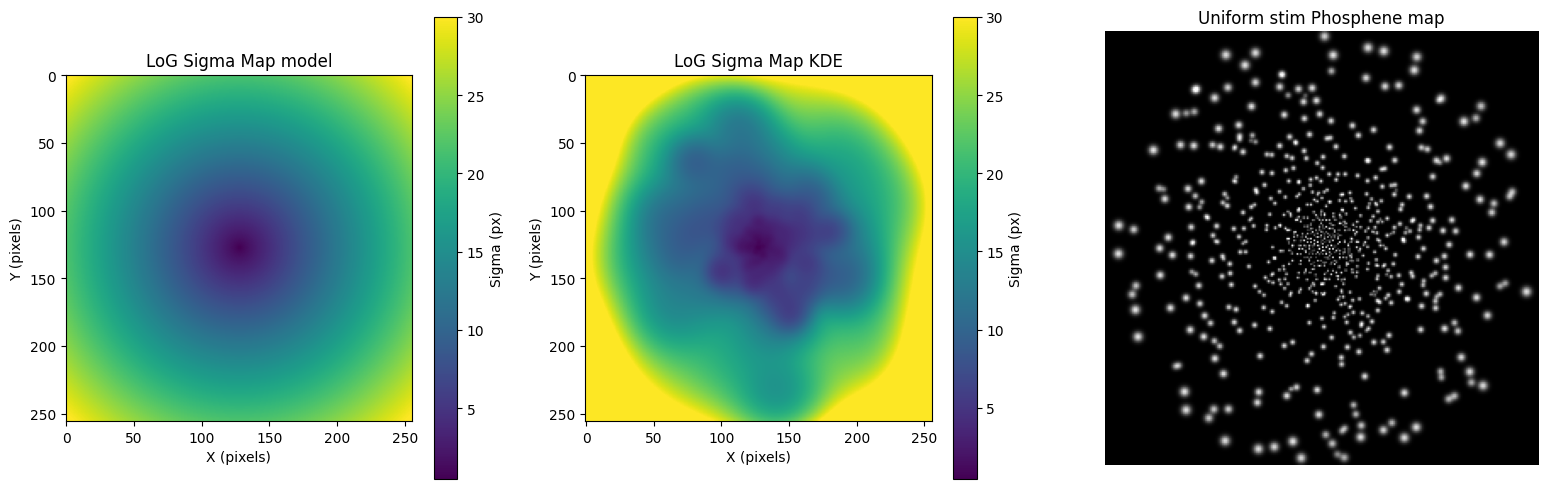

In [86]:
# plot sigma_fov_map
plt.figure(figsize=(19, 6))

plt.subplot(1, 3, 1)
plt.imshow(sigma_map_px, cmap='viridis', vmax=30)
plt.colorbar(label='Sigma (px)')
plt.title('LoG Sigma Map model')
plt.xlabel('X (pixels)')
plt.ylabel('Y (pixels)')

plt.subplot(1, 3, 2)
plt.imshow(kde_sigma_map_px, cmap='viridis', vmax=30)
plt.colorbar(label='Sigma (px)')
plt.title('LoG Sigma Map KDE')
plt.xlabel('X (pixels)')
plt.ylabel('Y (pixels)')

plt.subplot(1, 3, 3)
plt.imshow(phos_weighted.cpu().numpy(), cmap='gray')
plt.title("Uniform stim Phosphene map")
plt.gca().set_facecolor('black')
plt.axis('off')

plt.show()

In [87]:
sigma_map_tensor = torch.Tensor(kde_sigma_map_px).float().cuda().unsqueeze(0).unsqueeze(0)
in_channels = 1
out_channels = 1
kernel_size = 1
net = FovConv2dCont(in_channels, out_channels, kernel_size, kernel_type='LoG', sigma_map=sigma_map_tensor,
                    log_kernel_size=99, sigma_function='map', padding_mode='reflect').cuda()

foa_xy = torch.tensor([128, 128]).float().cuda().unsqueeze(0)

/gpfs/home1/mappel/Dynaphos/spatial_frequency/notebooks/./../components/fov_conv2d_cont.py:298: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.sigma_map = torch.tensor(sigma_map, dtype=torch.float32)


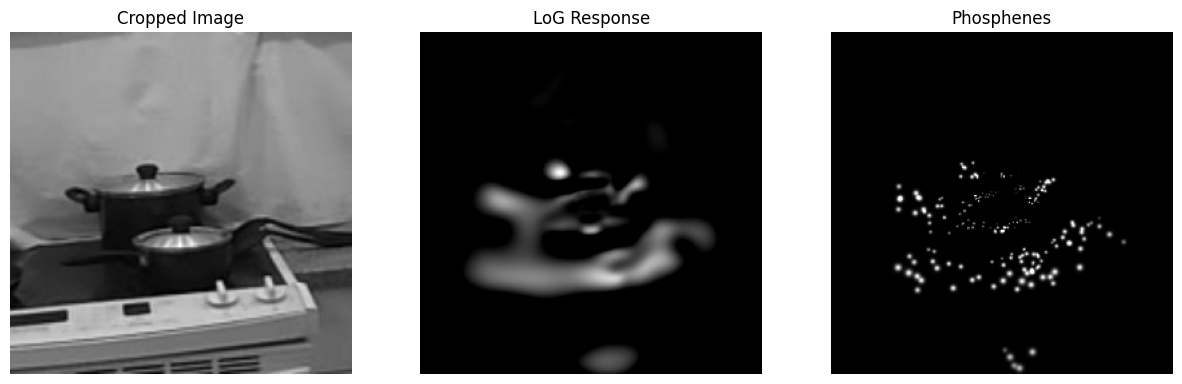

In [88]:
image = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
image_tensor = torch.Tensor(image).float().cuda().unsqueeze(0).unsqueeze(0)

response = net(image_tensor, foa_xy).clip(0, None)
response = (response - response.min()) / (response.max() - response.min())
response = response.squeeze().cpu().detach().numpy()

stimulus = torch.tensor(response).float().cuda()
simulator.reset()
phosphenes = simulator(simulator.sample_stimulus(stimulus, rescale=True)*3*stim_weights) 

plt.figure(figsize=(15, 8))

plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Cropped Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(response, cmap='gray')
plt.title('LoG Response')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(phosphenes.cpu(), cmap='gray')
plt.title('Phosphenes')
plt.axis('off')

plt.show()

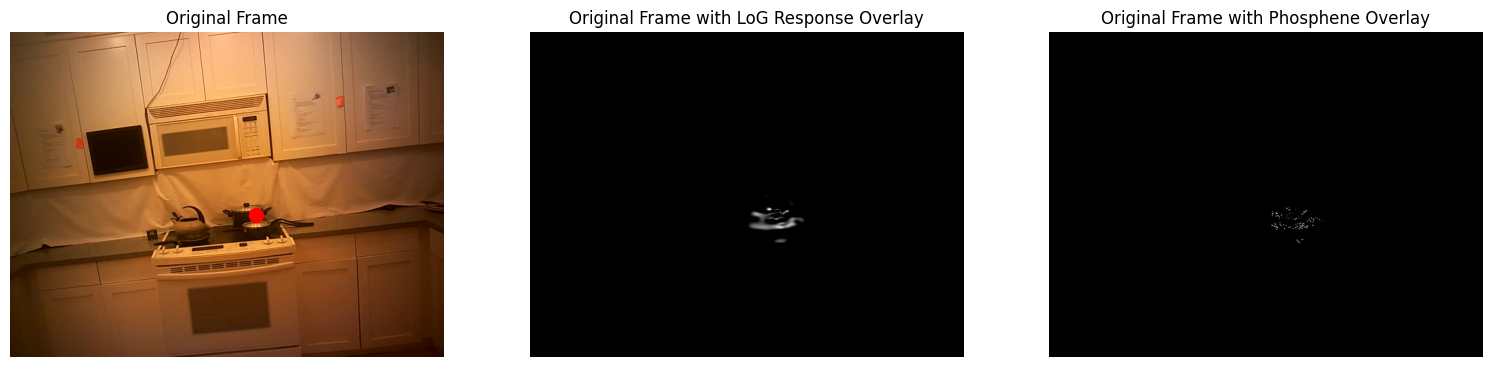

In [89]:
def overlay_phosphene(original_frame, phosphene_image, gaze_x, gaze_y, fov_camera=90, fov_phosphene=16):
    """
    Overlay the phosphene image back into the original frame space.

    Parameters:
        original_frame (numpy array): Original frame (grayscale, e.g., 640x480).
        phosphene_image (numpy array): Phosphene image (grayscale, e.g., 256x256).
        gaze_x (float): Normalized gaze x-coordinate (0 to 1).

    Returns:
        combined_image (numpy array): Image with phosphene overlaid.
    """
    # Ensure the frame is black initially float32
    frame_height, frame_width = original_frame.shape[:2]
    combined_image = np.zeros((frame_height, frame_width), dtype=np.float32)

    # Convert normalized gaze coordinates to pixel positions
    x_center = int(gaze_x * frame_width)
    y_center = int(gaze_y * frame_height)

    # Get phosphene image dimensions
    phos_h, phos_w = phosphene_image.shape
    # resize the phosphene image proportionally to the fovs
    phos_w = int(frame_width * (fov_phosphene / fov_camera))
    phos_h = int(frame_height * (fov_phosphene / fov_camera))

    # resize the phosphene image to the new size
    phosphene_image = cv2.resize(phosphene_image, (phos_w, phos_h))

    # Compute the top-left corner of the phosphene placement
    x1 = max(0, x_center - phos_w // 2)
    y1 = max(0, y_center - phos_h // 2)
    x2 = min(frame_width, x_center + phos_w // 2)
    y2 = min(frame_height, y_center + phos_h // 2)

    # Compute the region of the phosphene image to use
    phos_x1 = max(0, phos_w // 2 - x_center)
    phos_y1 = max(0, phos_h // 2 - y_center)
    phos_x2 = phos_x1 + (x2 - x1)
    phos_y2 = phos_y1 + (y2 - y1)

    # Overlay the phosphene onto the combined image
    combined_image[y1:y2, x1:x2] = phosphene_image[phos_y1:phos_y2, phos_x1:phos_x2]

    return combined_image

overlayed_response = overlay_phosphene(
    original_frame=frame,
    phosphene_image=response,
    gaze_x=gaze_x,
    gaze_y=gaze_y,
)

overlayed_phosphenes = overlay_phosphene(
    original_frame=frame,
    phosphene_image=phosphenes.cpu().numpy(),
    gaze_x=gaze_x,
    gaze_y=gaze_y,
)

# Display the result side by side with the original frame
plt.figure(figsize=(19, 12))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
# overlay
plt.scatter(gaze_x_px, gaze_y_px, color='red', s=100)
plt.title("Original Frame")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(overlayed_response, cmap="gray")
plt.title("Original Frame with LoG Response Overlay")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(overlayed_phosphenes, cmap="gray")
plt.title("Original Frame with Phosphene Overlay")
plt.axis("off")
plt.show()

# Smooth Gaze Data for blinks

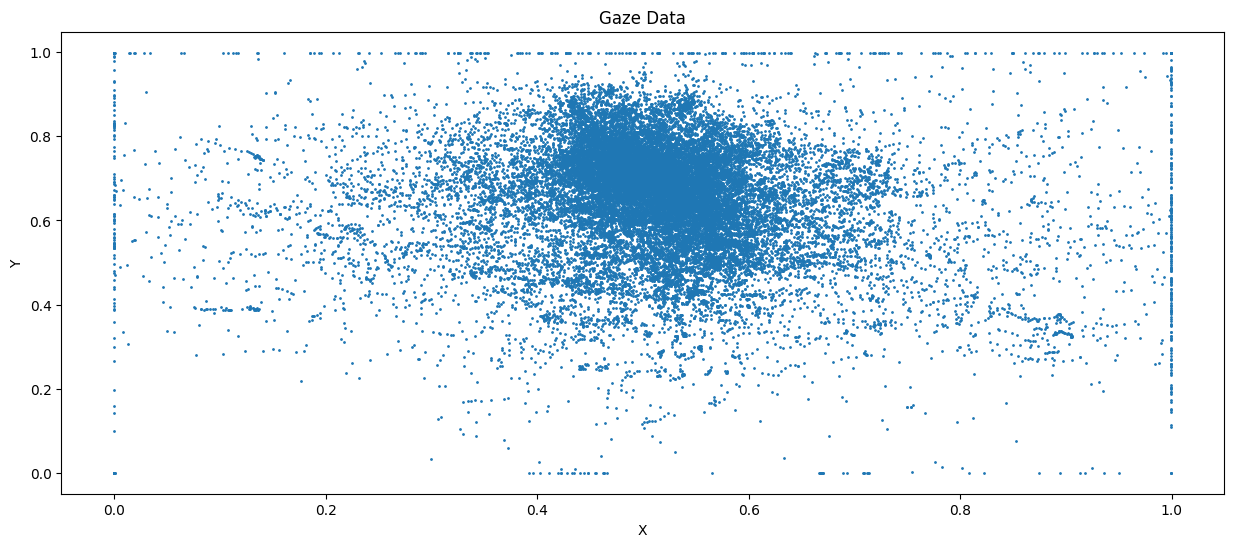

In [90]:
# plot eye gaze data
plt.figure(figsize=(15, 6))
# scatterplot x,y gaze data
plt.scatter(gaze_data[:,0], gaze_data[:,1], s=1)
plt.title('Gaze Data')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [91]:
blink_epsilon = 0.05
# find blinks where x or y is less than epsilon or more than 1-epsilon
blink_indices = np.where(
    (gaze_data[:,0] < blink_epsilon) | (gaze_data[:,0] > 1-blink_epsilon) |
    (gaze_data[:,1] < blink_epsilon) | (gaze_data[:,1] > 1-blink_epsilon)
)[0]

# n many blnks found
print(len(blink_indices), 'blinks found')

3582 blinks found


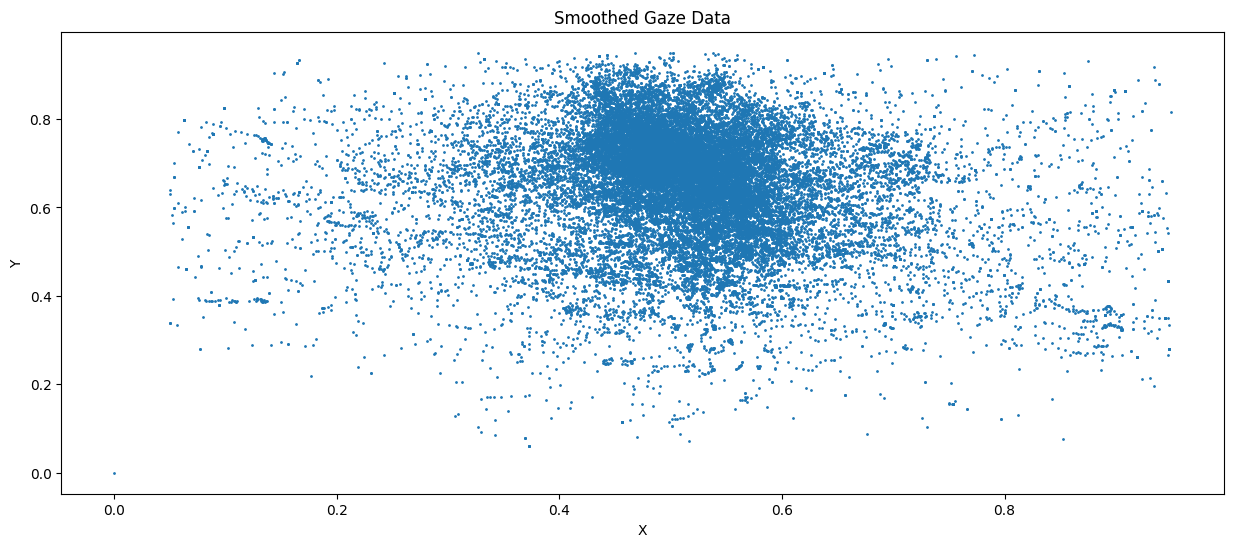

In [92]:
# wherever the blink is, set the gaze point to the last valid gaze point
smnoothed_gaze_data = gaze_data.copy()
for i in blink_indices:
    smnoothed_gaze_data[i] = smnoothed_gaze_data[i-1]

# plot eye gaze data
plt.figure(figsize=(15, 6))
# scatterplot x,y gaze data
plt.scatter(smnoothed_gaze_data[:,0], smnoothed_gaze_data[:,1], s=1)
plt.title('Smoothed Gaze Data')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


# Video processing

In [94]:
file_name = "OP01-R01-PastaSalad"

# Path to the gaze data file
gaze_data_path = f"../data/EGTEA/Gaze_Data/gaze_data/gaze_data/{file_name}.txt"
gaze_data = parse_gtea_gaze(gaze_data_path)
gaze_data.shape

# Path to the video file
video_path = f"../data/EGTEA/Raw_Videos/{file_name}.mp4"

out_path = f"../out/{file_name}_phosphene_camFOV{camera_fov}_phosFOV_{phosphene_fov}_corticalmag_demo_50sec.mp4"
out_path

'../out/OP01-R01-PastaSalad_phosphene_camFOV70_phosFOV_16_corticalmag_demo_50sec.mp4'

In [ ]:
framerate = 30
max_n_frames = 50*framerate

cap = cv2.VideoCapture(video_path)
# print length of video
length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(length, 'frames')

35924 frames


In [99]:
# Define the frame resolution and crop size
camera_fov = 70  # Camera field of view in degrees, this is an estimate, i can't find online what the actual fov is
phosphene_fov = 16
# based on fovs
ratio = phosphene_fov / camera_fov 
crop_size = int(frame_width * ratio)
resize = 256  # Resize the cropped region to 256x256

In [102]:
cap = cv2.VideoCapture(video_path)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

if not cap.isOpened():
    print('Unable to read file :(')

# Set the output stream
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(out_path, fourcc, framerate, (frame_width,3*frame_height), isColor=True)

# Loop over frames
frame_nr = 0
while frame_nr<max_n_frames:
    # load next frame
    ret, frame = cap.read()
    frame_nr+=1
    
    if not ret:
        break 

    # Get the gaze data for the specific frame
    gaze_point = smnoothed_gaze_data[frame_nr, :]
    if gaze_point[2] == 4:  # Gaze truncated (out of bounds)
        print(f"Frame {frame_nr}: Gaze point out of bounds.")
        continue
    else:
        gaze_x, gaze_y = gaze_point[0], gaze_point[1]


    # crop around gaze point    
    cropped = crop_frame(frame, gaze_x, gaze_y, resize=resize, crop_size=crop_size)
    # to grayscale
    cropped = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
    cropped_tensor = torch.Tensor(cropped).float().cuda().unsqueeze(0).unsqueeze(0)

    # LoG response
    response = net(cropped_tensor, foa_xy).clip(0, None)
    response = (response - response.min()) / (response.max() - response.min())
    response_numpy = response.squeeze().cpu().detach().numpy()

    # overlay LoG response
    overlayed_response = overlay_phosphene(
        original_frame=frame,
        phosphene_image=response_numpy,
        gaze_x=gaze_x,
        gaze_y=gaze_y,
        fov_camera=camera_fov,
        fov_phosphene=phosphene_fov
    )

    simulator.reset()
    phosphenes = simulator(simulator.sample_stimulus(response, rescale=True)*3*stim_weights).detach().cpu()

    # overlay phosphenes
    overlayed_phosphenes = overlay_phosphene(
        original_frame=frame,
        phosphene_image=phosphenes.cpu().numpy(),
        gaze_x=gaze_x,
        gaze_y=gaze_y,
        fov_camera=camera_fov,
        fov_phosphene=phosphene_fov
    )

    # make response_img and phosphenes_img have 3 channels
    response_img = overlayed_response*255
    phosphenes_img = overlayed_phosphenes*255

    # Convert 1-channel grayscale images to 3-channel images
    response_img_3ch = cv2.cvtColor(response_img.astype('uint8'), cv2.COLOR_GRAY2BGR)
    phosphenes_img_3ch = cv2.cvtColor(phosphenes_img.astype('uint8'), cv2.COLOR_GRAY2BGR)

    # add red dot for gaze point over frame
    gaze_x_px = int(gaze_x * frame_width)
    gaze_y_px = int(gaze_y * frame_height)
    cv2.circle(frame, (gaze_x_px, gaze_y_px), radius=10, color=(0, 0, 255), thickness=-1)  # Red dot

    cat = np.concatenate([frame, response_img_3ch, phosphenes_img_3ch], axis=0).astype('uint8')
    
    out.write(cat)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
out.release() 

cv2.destroyAllWindows()